In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#required packages.
import numpy as np
import pandas as pd
from pandas import Timestamp
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import datetime
import itertools
import argparse
import collections
from datetime import datetime, timedelta

Prior to using the Earth Engine Python client library, you need to authenticate (verify your identity) and use the resultant credentials to initialize the Python client. The authentication flows use Cloud Projects to authenticate, and they're used for unpaid (free, noncommercial) use as well as paid use. To authenticate and initialize, run the following codes.

https://developers.google.com/earth-engine/guides/auth


In [2]:
import ee
# # Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize(project='')

## climate features

### temperature features

#### point based features

In [ ]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

def get_land_surface_temperature(r_lon, r_lat, i_date, f_date, selected_band):
    """Get land surface temperature over selected area"""
    # Get the data for the pixel intersecting the point
    scale = 1000  # scale in meters

    # Define the rural location of interest as a point away from the city.
    r_poi = ee.Geometry.Point(r_lon, r_lat)

    # Import the MODIS land surface temperature collection.
    lst = ee.ImageCollection('MODIS/006/MOD11A1')

    # Selection of appropriate bands and dates for LST.
    lst = lst.select(selected_band, 'QC_Day').filterDate(i_date, f_date)

    lst_r_poi = lst.getRegion(r_poi, scale).getInfo()

    lst_df_urban = ee_array_to_df(lst_r_poi,[selected_band])

    # Apply the function to get temperature in celsius.
    lst_df_urban[selected_band] = lst_df_urban[selected_band].apply(t_modis_to_celsius)

    return lst_df_urban

def get_modis_weather(r_lon, r_lat, start, end):
    #expand the selected period
    start_time_0 = datetime.datetime.strptime(start, "%Y-%m-%d") - datetime.timedelta(31)
    end_time_0 = datetime.datetime.strptime(end, "%Y-%m-%d") + datetime.timedelta(31)
    start_time = str(start_time_0)[:10]
    end_time = str(end_time_0)[:10]

    lst_df_night = get_land_surface_temperature(r_lon, r_lat, start_time, end_time, "LST_Night_1km")
    lst_df_day = get_land_surface_temperature(r_lon, r_lat, start_time, end_time, "LST_Day_1km")

    #combine the weather data
    lst_df_night["maxTemp"] = lst_df_day['LST_Day_1km']
    lst_df_night.index = pd.DatetimeIndex(lst_df_night['datetime'])
    lst_df_night = lst_df_night.rename(columns={"datetime":"date", "LST_Night_1km":"minTemp"})

    #resample the data daily
    Dailydat = lst_df_night.resample('D', on='date').sum()
    Dailydat['date'] = Dailydat.index

    #replace 0.0 with nan
    Dailydat.replace(0.0, np.nan, inplace=True)

    #estimate missing values
    Dailydat['minTemp'] = Dailydat['minTemp'].interpolate(method='polynomial', order=2)
    Dailydat['maxTemp'] = Dailydat['maxTemp'].interpolate(method='polynomial', order=2)

    #select interested period
    mask = (Dailydat['date'] >= start) & (Dailydat['date'] <= end)
    modis_weather = Dailydat.loc[mask]

    return modis_weather

In [ ]:
#input parameters
start, end = '2021-01-01', '2021-12-31'
r_lon, r_lat = 141.4377389809555, -30.95203025969217

get_modis_weather(r_lon, r_lat, start, end)

<ipython-input-5-3480d46cf410>:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Dailydat.replace(0.0, np.nan, inplace=True)


,time,minTemp,maxTemp,date
date,,,,
2021-01-01,1.609459e+12,24.690000,43.265570,2021-01-01
2021-01-02,1.609546e+12,20.110000,42.430000,2021-01-02
2021-01-03,NaN,21.185106,38.687100,2021-01-03
2021-01-04,1.609718e+12,22.390000,37.910000,2021-01-04
2021-01-05,1.609805e+12,18.370000,43.270000,2021-01-05
...,...,...,...,...
2021-12-27,1.640563e+12,15.430000,50.754220,2021-12-27
2021-12-28,NaN,16.894982,50.755751,2021-12-28
2021-12-29,1.640736e+12,20.990000,50.687678,2021-12-29


In [ ]:
start, end = '2017-01-01', '2022-10-22'
r_lon, r_lat = 43.8013010106828, 40.2593968535794

weather_data = get_modis_weather(r_lon, r_lat, start, end)
weather_data

<ipython-input-5-3480d46cf410>:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Dailydat.replace(0.0, np.nan, inplace=True)


,time,minTemp,maxTemp,date
date,,,,
2017-01-01,NaN,-19.806251,-3.396652,2017-01-01
2017-01-02,NaN,-18.377430,-4.727696,2017-01-02
2017-01-03,NaN,-17.156475,-5.899684,2017-01-03
2017-01-04,NaN,-16.143384,-6.912614,2017-01-04
2017-01-05,NaN,-15.338158,-7.766487,2017-01-05
...,...,...,...,...
2022-10-18,NaN,10.654891,26.032144,2022-10-18
2022-10-19,NaN,9.693970,27.127642,2022-10-19
2022-10-20,NaN,8.786457,27.872158,2022-10-20


#### Image download

In [ ]:
def get_time_series_Imgs(aoi, target_band, i_date, f_date, scale):
    bandImages = (ee.ImageCollection("MODIS/006/MOD11A1")
              .filterBounds(aoi)
              .select([target_band])
              .filterDate(i_date, f_date)
              .sort('system:time_start')
              .toBands())
              # .clip(aoi))
    #using the median value of multi bands
    bandImages = bandImages.reproject(crs = ee.Projection('EPSG:4326'), scale=scale)
    band_arr = bandImages.sampleRectangle(aoi, defaultValue=0)

    #getting
    dics = band_arr.getInfo()

    #collecting images
    time_key_list = list(dics['properties'].keys())
    ImgTS = np.array(dics['properties'][time_key_list[0]])
    for idx in range(1, len(time_key_list)):
        cur_key = list(dics['properties'].keys())[idx]
        Img1 = np.array(dics['properties'][cur_key])
        ImgTS = np.dstack((ImgTS, Img1))
    return ImgTS, time_key_list

In [ ]:
#input parameters
aoi = ee.Geometry.Polygon(
      [[[1.665586676010049, 48.55860495478288],
        [1.665586676010049, 48.536502067708305],
        [1.7085878509368069, 48.536502067708305],
        [1.7085878509368069, 48.55860495478288]]])
target_band = 'LST_Day_1km'
i_date, f_date = '2018-11-01', '2018-12-31'
scale = 10

ImgTS, time_key_list = get_time_series_Imgs(aoi, target_band, i_date, f_date, scale)
ImgTS.shape, len(time_key_list)

((247, 479, 60), 60)

In [ ]:
def generate_time_intervals(start_date, end_date, interval_length_days):
    """generate time intervals from start_date to end_date with a specified interval length in days"""
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    intervals = []

    while start < end:
        interval_end = start + timedelta(days=interval_length_days)
        if interval_end > end:
            interval_end = end
        intervals.append((start.strftime("%Y-%m-%d"), interval_end.strftime("%Y-%m-%d")))
        start = interval_end

    return intervals

# slit the whole time series into intervals
time_intervals = generate_time_intervals("2018-01-01", "2018-12-31", 59)  # Approx. 2-month intervals
print(time_intervals)

[('2018-01-01', '2018-03-01'), ('2018-03-01', '2018-04-29'), ('2018-04-29', '2018-06-27'), ('2018-06-27', '2018-08-25'), ('2018-08-25', '2018-10-23'), ('2018-10-23', '2018-12-21'), ('2018-12-21', '2018-12-31')]


In [ ]:
aoi = ee.Geometry.Polygon(
      [[[1.665586676010049, 48.55860495478288],
        [1.665586676010049, 48.536502067708305],
        [1.7085878509368069, 48.536502067708305],
        [1.7085878509368069, 48.55860495478288]]])
target_band = 'LST_Day_1km'


time_indexes = []
ImgTS_total = np.zeros((ImgTS.shape[0], ImgTS.shape[1]))
for interval in time_intervals:
    i_date, f_date = interval[0], interval[1]
    ImgTS, time_key_list = get_time_series_Imgs(aoi, target_band, i_date, f_date, scale)

    #generate temporal mean images
    ImgTS_mean = np.mean(ImgTS, axis=2)
    ImgTS_total = np.dstack((ImgTS_total, ImgTS_mean))
    time_indexes += time_key_list

ImgTS_total.shape, len(time_indexes)

((247, 479, 365), 364)

#### MOSAIC image
* need to reference landsat image downloading function to prepare new function

In [ ]:
def get_modis_time_series_image(aoi_modis, target_band, i_date, f_date):
    #Load a collection
    TERRA = (ee.ImageCollection("MODIS/006/MOD09A1")
              .filterBounds(aoi_modis)
              .filterDate(i_date, f_date)
              .sort('system:time_start'))

    #Extract an image
    TERRA_list = TERRA.toList(TERRA.size())

    numpy_array = []
    for i in range(TERRA.size().getInfo()):
        Terra_img = ee.Image(TERRA_list.get(i))
        sample = Terra_img.select(target_band).sampleRectangle(region = aoi_modis)
        numpy_array_new = np.array(sample.get(target_band).getInfo())
        numpy_array.append(numpy_array_new)
    numpy_array = np.array(numpy_array)

    return numpy_array

In [ ]:
def get_modis_time_series_image_new(aoi_modis, target_band, i_date, f_date, scale):
    # Load a collection
    TERRA = (ee.ImageCollection("MODIS/006/MOD11A1")
              .select([target_band])
              .filterDate(i_date, f_date)
              .filterBounds(aoi_modis)  # Add this line to filter images containing AOI
              .sort('system:time_start'))

    # Extract an image
    TERRA_list = TERRA.toList(TERRA.size())

    numpy_array = []
    for i in range(TERRA.size().getInfo()):
        Terra_img = ee.Image(TERRA_list.get(i))
        #reproject image with user defined scale
        Terra_img = Terra_img.reproject(crs = ee.Projection('EPSG:4326'), scale=scale)

        # check if image footprint contains the AOI
        image_footprint = Terra_img.geometry()
        if image_footprint.contains(aoi_modis).getInfo():
            sample = Terra_img.select(target_band).sampleRectangle(region=aoi_modis, defaultValue=0)
            numpy_array_new = np.array(sample.get(target_band).getInfo())
            numpy_array.append(numpy_array_new)
        else:
            print(f"Image {i} does not contain the AOI")
    numpy_array = np.array(numpy_array)
    return numpy_array

In [ ]:
#input parameter
aoi = ee.Geometry.Polygon(
        [[[1.665586676010049, 48.55860495478288],
          [1.665586676010049, 48.536502067708305],
          [1.7085878509368069, 48.536502067708305],
          [1.7085878509368069, 48.55860495478288]]])
target_band = 'LST_Day_1km'
i_date, f_date = '2017-12-01', '2019-01-31'
scale = 10
ImgTS_total_day = get_modis_time_series_image_new(aoi, target_band, i_date, f_date, scale)
ImgTS_total_day.shape

(426, 247, 479)

In [ ]:
#input parameters
target_band = 'LST_Night_1km'
i_date, f_date = '2017-12-01', '2019-01-31'
scale = 10
ImgTS_total_night = get_modis_time_series_image_new(aoi, target_band, i_date, f_date, scale)
print(ImgTS_total_night.shape)

(426, 247, 479)


In [ ]:
#processing images point by point
#[30,-30]
idx = 10
r_lon, r_lat = 1.665586676010049, 48.55860495478288
i_date, f_date = '2017-12-01', '2019-01-30'
modis_weather = get_modis_weather(r_lon, r_lat, i_date, f_date)

<ipython-input-28-896be3555107>:86: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Dailydat = lst_df_night.resample('D', on='date').sum()
<ipython-input-28-896be3555107>:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modis_weather['GDD'] = modis_weather.apply(lambda row : growing_degree_days(row), axis=1)


In [ ]:
def get_temperature_gdd(modis_weather, lst_d, lst_n, start, end):
    modis_weather['maxTemp'] = np.array(lst_d) * 0.02 - 273.15
    modis_weather.loc[modis_weather['maxTemp'] < 0, 'maxTemp'] = np.nan

    #day weather
    modis_weather['minTemp'] = np.array(lst_n) * 0.02 - 273.15
    modis_weather.loc[modis_weather['minTemp'] < 0, 'minTemp'] = np.nan

    #estimate missing values
    modis_weather['minTemp'] = modis_weather['minTemp'].interpolate(method='polynomial', order=2)
    modis_weather['maxTemp'] = modis_weather['maxTemp'].interpolate(method='polynomial', order=2)

    #select interested period
    mask = (modis_weather['date'] >= start) & (modis_weather['date'] <= end)
    modis_weather = modis_weather.loc[mask]
    #select interested period
    mask = (modis_weather['date'] >= start) & (modis_weather['date'] <= end)
    whr = modis_weather.loc[mask]
    #adding to the lists
    minTemp = whr['minTemp'].mean()
    maxTemp = whr['maxTemp'].mean()
    GDD_sum = whr['GDD'].sum()
    GDD_mean = whr['GDD'].std()
    GDD_std = whr['GDD'].mean()

    return minTemp, maxTemp, GDD_sum, GDD_mean, GDD_std

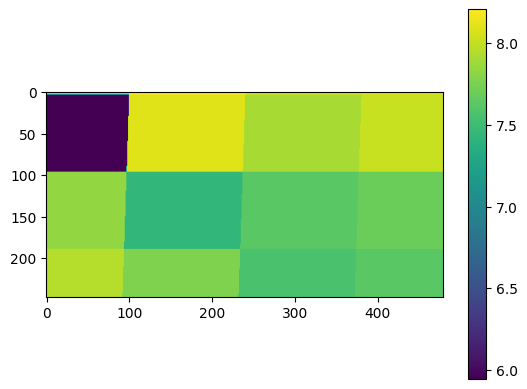

In [ ]:
plt.imshow(minTempV)
plt.colorbar()

### ECMWF features

* ERA5-Land Daily Aggregated - ECMWF Climate Reanalysis https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_DAILY_AGGR#bands

#### point based all features

In [ ]:
def ee_array_to_df1(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors="coerce")

    # Convert the time field into a datetime.
    df["datetime"] = pd.to_datetime(df["time"], unit="ms")

    # Keep the columns of interest.
    df = df[["time", "datetime", *list_of_bands]]

    # The datetime column is defined as index.
    df = df.set_index("datetime")

    return df

def get_ECMWF_features(r_lon, r_lat, selected_features, scale, i_date, f_date):
    # Import soil temperature.

    pr = (ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
        .select(selected_features)
        .filterDate(i_date, f_date))

    # Define the location of interest with a point.
    poi = ee.Geometry.Point(r_lon, r_lat)
    # Evaluate local precipitation conditions.
    local_pr = pr.getRegion(poi, scale).getInfo()
    pr_df = ee_array_to_df1(local_pr, selected_features)

    return pr_df

def compute_climate_statistics(dfc, climate_feature_mean_dics, climate_feature_std_dics, climate_feature_sum_dics):
      #compute statistics of the target feature
    dfcd = dfc.describe()
    #getting dictionary names
    dfc_mean = dfcd.loc[['mean']].reset_index(drop=True)
    dfc_std = dfcd.loc[['std']].reset_index(drop=True)
    dfc_sum = dfc.agg(['sum']).reset_index(drop=True)

    #update the column names
    dfc_mean.rename(climate_feature_mean_dics, axis=1, inplace=True)
    dfc_std.rename(climate_feature_std_dics, axis=1, inplace=True)
    dfc_sum.rename(climate_feature_sum_dics, axis=1, inplace=True)
    dfclimate = pd.concat([dfc_mean, dfc_std, dfc_sum], axis=1)

    return dfclimate

def get_new_data_features(data2,
                          selected_features,
                          scale,
                          start_date, end_date,
                          climate_feature_mean_dics,
                          climate_feature_std_dics,
                          climate_feature_sum_dics,
                          select_data2_features):
    r_lon, r_lat = data2['TH_LONG'][idx], data2['TH_LAT'][idx]

    #download ecmwf features
    dfc = get_ECMWF_features(r_lon, r_lat, selected_features, scale, start_date, end_date)

    #compute_climate_statistics
    dfclimate = compute_climate_statistics(dfc, climate_feature_mean_dics, climate_feature_std_dics, climate_feature_sum_dics)

    #merge current vegetation indices with related disease feature
    temp_feature = data2.iloc[[idx]][select_data2_features]
    temp_feature = temp_feature.reset_index(drop = True)
    merged_features = pd.concat([temp_feature, dfclimate], axis=1)

    return merged_features

In [ ]:
#generating initial features ecmwf
scale = 1000  # scale in meters
#basic example
r_lon, r_lat = 12.823965, 51.167514
i_date, f_date = '2015-01-01', '2015-12-31'

pr = (ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
    .filterDate(i_date, f_date))

# Define the location of interest with a point.
poi = ee.Geometry.Point(r_lon, r_lat)
# Evaluate local precipitation conditions.
local_pr = pr.getRegion(poi, scale).getInfo()
#convert to pandas dataframe
selected_features = local_pr[0][4:]
pr_df = ee_array_to_df1(local_pr, selected_features)

len(local_pr[0]), local_pr[0]

<ipython-input-7-4ce089c159b7>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["datetime"] = pd.to_datetime(df["time"], unit="ms")


(154,
 ['id',
  'longitude',
  'latitude',
  'time',
  'dewpoint_temperature_2m',
  'temperature_2m',
  'skin_temperature',
  'soil_temperature_level_1',
  'soil_temperature_level_2',
  'soil_temperature_level_3',
  'soil_temperature_level_4',
  'lake_bottom_temperature',
  'lake_ice_depth',
  'lake_ice_temperature',
  'lake_mix_layer_depth',
  'lake_mix_layer_temperature',
  'lake_shape_factor',
  'lake_total_layer_temperature',
  'snow_albedo',
  'snow_cover',
  'snow_density',
  'snow_depth',
  'snow_depth_water_equivalent',
  'snowfall_sum',
  'snowmelt_sum',
  'temperature_of_snow_layer',
  'skin_reservoir_content',
  'volumetric_soil_water_layer_1',
  'volumetric_soil_water_layer_2',
  'volumetric_soil_water_layer_3',
  'volumetric_soil_water_layer_4',
  'forecast_albedo',
  'surface_latent_heat_flux_sum',
  'surface_net_solar_radiation_sum',
  'surface_net_thermal_radiation_sum',
  'surface_sensible_heat_flux_sum',
  'surface_solar_radiation_downwards_sum',
  'surface_thermal_ra

In [ ]:
#preparing new features
selected_features = local_pr[0][4:]
#create feature dictionary
climate_feature_mean_dics = {}
climate_feature_std_dics = {}
climate_feature_sum_dics = {}
for cur_feature in local_pr[0][4:]:
    climate_feature_mean_dics[cur_feature] = cur_feature + "_mean"
    climate_feature_std_dics[cur_feature] = cur_feature + "_std"
    climate_feature_sum_dics[cur_feature] = cur_feature + "_sum"

#initialize the new dataframe
climate_features = list(climate_feature_mean_dics.values()) + list(climate_feature_std_dics.values()) + list(climate_feature_sum_dics.values())
data_features = pd.DataFrame(columns=list(data2.keys())[:7] + climate_features)
data_features

,Unnamed: 0,POINTID,SURVEY_DATE,TH_LAT,TH_LONG,OC,B1,dewpoint_temperature_2m_mean,temperature_2m_mean,skin_temperature_mean,...,v_component_of_wind_10m_min_sum,v_component_of_wind_10m_max_sum,surface_pressure_min_sum,surface_pressure_max_sum,total_precipitation_min_sum,total_precipitation_max_sum,leaf_area_index_high_vegetation_min_sum,leaf_area_index_high_vegetation_max_sum,leaf_area_index_low_vegetation_min_sum,leaf_area_index_low_vegetation_max_sum


In [ ]:
# import data
file_path = ''# you pandas file path
df_id = pd.read_csv(file_path)
df_id.head()

,Unnamed: 0,point_id
0,0,54042624
1,1,51003392
2,2,55442642
3,3,51003396
4,4,50462726


#### point based

In [ ]:
def ee_array_to_df1(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors="coerce")

    # Convert the time field into a datetime.
    df["datetime"] = pd.to_datetime(df["time"], unit="ms")

    # Keep the columns of interest.
    df = df[["time", "datetime", *list_of_bands]]

    # The datetime column is defined as index.
    df = df.set_index("datetime")

    return df

def get_ECMWF_features(r_lon, r_lat, selected_features, scale, i_date, f_date):
    # Import soil temperature.

    pr = (ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
        .select(selected_features)
        .filterDate(i_date, f_date))

    # Define the location of interest with a point.
    poi = ee.Geometry.Point(r_lon, r_lat)
    # Evaluate local precipitation conditions.
    local_pr = pr.getRegion(poi, scale).getInfo()
    pr_df = ee_array_to_df1(local_pr, selected_features)

    return pr_df

In [ ]:
selected_features = ["soil_temperature_level_1", "soil_temperature_level_2","runoff_sum",'surface_net_solar_radiation_sum','evaporation_from_bare_soil_sum',
                     'potential_evaporation_sum','total_precipitation_sum']
scale = 1000  # scale in meters
#basic example
r_lon, r_lat = 2.823965, 51.167514
i_date, f_date = '2015-01-01', '2015-12-31'

#download ecmwf features
dfc = get_ECMWF_features(r_lon, r_lat, selected_features, scale, i_date, f_date)
dfc

,time,soil_temperature_level_1,soil_temperature_level_2,runoff_sum,surface_net_solar_radiation_sum,evaporation_from_bare_soil_sum,potential_evaporation_sum,total_precipitation_sum
datetime,,,,,,,,
2015-01-01,1420070400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,1420156800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,1420243200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,1420329600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,1420416000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2015-12-26,1451088000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-27,1451174400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-28,1451260800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Image based

* 'potential_evaporation_sum_std','potential_evaporation_sum_sum','potential_evaporation_sum_mean',
'surface_net_solar_radiation_sum_std','soil_temperature_level_2_mean','soil_temperature_level_1_sum','minTemps','soil_temperature_level_1_mean','runoff_sum_mean'

In [ ]:
def get_time_series_images(aoi, image_source, target_band, i_date, f_date, scale):
    # Load a collection
    TERRA = (ee.ImageCollection(image_source)
              .select([target_band])
              .filterDate(i_date, f_date)
              .filterBounds(aoi)  # Add this line to filter images containing AOI
              .sort('system:time_start'))

    # Extract an image
    TERRA_list = TERRA.toList(TERRA.size())

    numpy_array = []
    for i in range(TERRA.size().getInfo()):
        Terra_img = ee.Image(TERRA_list.get(i))
        #reproject image with user defined scale
        Terra_img = Terra_img.reproject(crs = ee.Projection('EPSG:4326'), scale=scale)

        # check if image footprint contains the AOI
        image_footprint = Terra_img.geometry()
        if image_footprint.contains(aoi).getInfo():
            sample = Terra_img.select(target_band).sampleRectangle(region=aoi)
            numpy_array_new = np.array(sample.get(target_band).getInfo())
            numpy_array.append(numpy_array_new)
        else:
            print(f"Image {i} does not contain the AOI")
    numpy_array = np.array(numpy_array)
    return numpy_array

In [ ]:
#input parameter
aoi = ee.Geometry.Polygon(
        [[[1.665586676010049, 48.55860495478288],
          [1.665586676010049, 48.536502067708305],
          [1.7085878509368069, 48.536502067708305],
          [1.7085878509368069, 48.55860495478288]]])
i_date, f_date = '2018-01-01', '2018-12-31'
scale = 10
image_source = 'ECMWF/ERA5_LAND/DAILY_AGGR'

In [ ]:
target_band = 'runoff_sum'
runoff_sum = get_time_series_images(aoi, image_source, target_band, i_date, f_date, scale)
runoff_sum_mean = np.nanmean(runoff_sum, axis=0)
# np.save(path + 'gee2Ddata/runoff_sum_mean.npy', runoff_sum_mean)

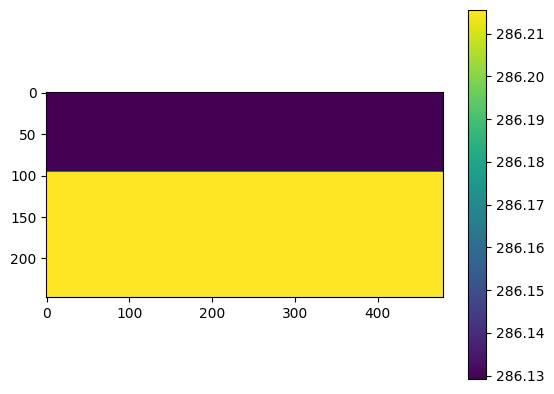

In [ ]:
plt.imshow(soil_temperature_level_1_mean)
plt.colorbar()

In [ ]:
target_band = 'potential_evaporation_sum'
ecmwf1 = get_time_series_images(aoi, image_source, target_band, i_date, f_date, scale)
print('results shape: ', ecmwf1.shape)

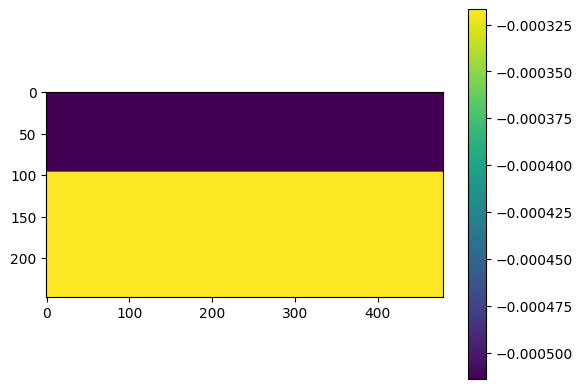

In [ ]:
plt.imshow(ecmwf1[1,:,:])
plt.colorbar()

In [ ]:
def get_std(image):
    clouds = (ee.Algorithms.Landsat.simpleCloudScore(image).select(['cloud']))
    std_image = image.updateMask(clouds.lt(20))
    return std_image

In [ ]:
poi = ee.Geometry.Point(r_lon, r_lat)
#collect landsat images
ecmwf = (ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
            .filterBounds(poi)
            .filterDate(i_date, f_date)
            .select(target_band)
            .mean())
#reproject image with user defined scale
ecmwf = ecmwf.reproject(crs = ee.Projection('EPSG:4326'), scale=scale)

#crop the interested areas
sample = ecmwf.select(target_band).sampleRectangle(region=aoi, defaultValue=0)
numpy_array = np.array(sample.get(target_band).getInfo())

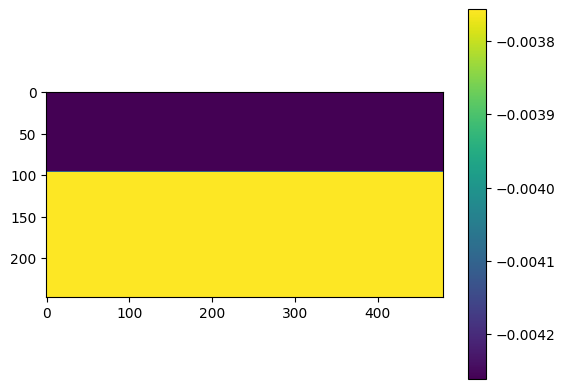

In [ ]:
plt.imshow(numpy_array)
plt.colorbar()

### Precipitation

* rainfall https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_MONTHLY#bands
* https://developers.google.com/earth-engine/tutorials/community/groundwater-recharge-estimation#from_soil_texture_to_hydraulic_properties

In [ ]:
def ee_array_to_df_v1(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors="coerce")

    # Convert the time field into a datetime.
    df["datetime"] = pd.to_datetime(df["time"], unit="ms")

    # Keep the columns of interest.
    df = df[["time", "datetime", *list_of_bands]]

    # The datetime column is defined as index.
    df = df.set_index("datetime")

    return df

def get_precipitation(r_lon, r_lat, scale, i_date, f_date):
    # Import precipitation.
    pr = (ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
        .select("precipitation")
        .filterDate(i_date, f_date))

    # Define the location of interest with a point.
    poi = ee.Geometry.Point(r_lon, r_lat)

    # Evaluate local precipitation conditions.
    local_pr = pr.getRegion(poi, scale).getInfo()
    pr_df = ee_array_to_df_v1(local_pr, ["precipitation"])

    return pr_df

In [ ]:
scale = 1000  # scale in meters
#basic example
r_lon, r_lat = 141.4377389809555, -30.95203025969217
i_date, f_date = '2021-01-01', '2021-05-01'
# Define the location of interest with a point.
poi = ee.Geometry.Point(r_lon, r_lat)
# download rainfall data
get_precipitation(r_lon, r_lat, scale, i_date, f_date)

,time,precipitation
datetime,,
2021-01-01,1609459200000,0.000000
2021-01-02,1609545600000,0.000000
2021-01-03,1609632000000,22.220366
2021-01-04,1609718400000,0.000000
2021-01-05,1609804800000,0.000000
...,...,...
2021-04-26,1619395200000,0.000000
2021-04-27,1619481600000,0.000000
2021-04-28,1619568000000,0.000000


### Getting PET

In [ ]:
def get_pet_test(r_lon, r_lat, scale, i_date, f_date):
    # Import potential evaporation PET.
    pet = (ee.ImageCollection("MODIS/006/MOD16A2")
        .select(["PET"])
        .filterDate(i_date, f_date))

    # Define the location of interest with a point.
    poi = ee.Geometry.Point(r_lon, r_lat)
    # Evaluate local potential evapotranspiration.
    local_pet = pet.getRegion(poi, scale).getInfo()

    # Transform the result into a pandas dataframe.
    pet_df = ee_array_to_df(local_pet, ["PET"])
    pet_df["PET"] = pet_df["PET"] * 0.1

    return pet_df

In [ ]:
scale = 1000  # scale in meters
#basic example
r_lon, r_lat = 141.4377389809555, -30.95203025969217
i_date, f_date = '2021-01-01', '2021-05-01'

get_pet_test(r_lon, r_lat, scale, i_date, f_date)

,time,datetime,PET


In [ ]:
#must run these codes
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

def get_pet(r_lon, r_lat, scale, i_date, f_date):
    # Import potential evaporation PET.
    pet = (ee.ImageCollection("MODIS/006/MOD16A2")
        .select(["PET"])
        .filterDate(i_date, f_date))

    # Define the location of interest with a point.
    poi = ee.Geometry.Point(r_lon, r_lat)
    # Evaluate local potential evapotranspiration.
    local_pet = pet.getRegion(poi, scale).getInfo()

    # Transform the result into a pandas dataframe.
    pet_df = ee_array_to_df(local_pet, ["PET"])
    pet_df["PET"] = pet_df["PET"] * 0.1

    #resample the data daily
    Dailydat = pet_df.resample('D', on='datetime').sum()
    Dailydat['date'] = Dailydat.index

    #replace 0.0 with nan
    Dailydat.replace(0.0, np.nan, inplace=True)

    #estimate missing values
    Dailydat['PET'] = Dailydat['PET'].interpolate(method='polynomial', order=2)

    return Dailydat

In [ ]:
get_pet(r_lon, r_lat, scale, i_date, f_date)

,time,datetime,PET
0,1420070400000,2015-01-01,15.6
1,1420761600000,2015-01-09,12.3
2,1421452800000,2015-01-17,13.0
3,1422144000000,2015-01-25,14.0
4,1422835200000,2015-02-02,17.5
5,1423526400000,2015-02-10,16.2
6,1424217600000,2015-02-18,21.4
7,1424908800000,2015-02-26,25.3
8,1425600000000,2015-03-06,33.2
9,1426291200000,2015-03-14,26.6


In [ ]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

def get_modis_fpar_lai(r_lon, r_lat, scale, i_date, f_date):
    # Import soil temperature.
    selected_features = ['Fpar', 'Lai']
    pr = (ee.ImageCollection('MODIS/006/MCD15A3H')
        .select(selected_features)
        .filterDate(i_date, f_date))

    # Define the location of interest
    poi = ee.Geometry.Point(r_lon, r_lat)
    # Evaluate local precipitation conditions.
    local_pr = pr.getRegion(poi, scale).getInfo()
    pr_df = ee_array_to_df(local_pr, selected_features)

    return pr_df

def get_modis_statistic_features(prd):
    dfcd = prd.describe()
    dfc_mean = dfcd.loc[['mean']].reset_index(drop=True)
    dfc_std = dfcd.loc[['std']].reset_index(drop=True)
    dfc_25p = dfcd.loc[['25%']].reset_index(drop=True)
    dfc_50p = dfcd.loc[['50%']].reset_index(drop=True)
    dfc_75p = dfcd.loc[['75%']].reset_index(drop=True)

    dfs2 = pd.concat([dfc_25p, dfc_50p, dfc_75p, dfc_mean, dfc_std], axis=1)

    return dfs2

In [ ]:
#collect MODIS features
scale = 100  # scale in meters
#interested time period
i_date, f_date = '2018-01-01', '2018-12-31'
r_lon, r_lat = 46.857320,13.893164

get_modis_fpar_lai(r_lon, r_lat, scale, i_date, f_date)

,time,datetime,Fpar,Lai
